<img src = "https://github.com/barcelonagse-datascience/academic_files/raw/master/bgsedsc_0.jpg">
$\newcommand{\bb}{\boldsymbol{\beta}}$
$\DeclareMathOperator{\Gau}{\mathcal{N}}$
$\newcommand{\bphi}{\boldsymbol \phi}$
$\newcommand{\bx}{\boldsymbol{x}}$
$\newcommand{\bu}{\boldsymbol{u}}$
$\newcommand{\by}{\boldsymbol{y}}$
$\newcommand{\whbb}{\widehat{\bb}}$
$\newcommand{\hf}{\hat{f}}$
$\newcommand{\tf}{\tilde{f}}$
$\newcommand{\ybar}{\overline{y}}$
$\newcommand{\E}{\mathbb{E}}$
$\newcommand{\Var}{Var}$
$\newcommand{\Cov}{Cov}$
$\newcommand{\Cor}{Cor}$

## Customer Churn Analysis and Classification

With the rapid development of telecommunication industry, the service providers are inclined more towards expansion of the subscriber base. To meet the need of surviving in the competitive environment, the retention of existing customers has become a huge challenge. It is stated that the cost of acquiring a new customer is far more than that for retaining the existing one. Therefore, it is imperative for the telecom industries to use advanced analytics to understand consumer behavior and in-turn predict the association of the customers as whether or not they will leave the company.

You are given a dataset: each row represents a customer and each column contains attributes related to customer as described:

+ Churn (target): 1 if customer cancelled service, 0 if not
+ AccountWeeks: number of weeks customer has had active account
+ ContractRenewal: 1 if customer recently renewed contract, 0 if not
+ DataPlan: 1 if customer has data plan, 0 if not
+ DataUsage: gigabytes of monthly data usage
+ CustServCalls: number of calls into customer service
+ DayMins: average daytime minutes per month
+ DayCalls: average number of daytime calls
+ MonthlyCharge: average monthly bill
+ OverageFee: largest overage fee in last 12 months
+ RoamMins: average number of roaming minutes


You are asked to **develop an algorithm** to be able to assess which are the customers that have the highest probability to churn. Besides that you will be asked to answer the 3 following questions:

1. **What variables are contributing to customer churn?** 
2. **Who are the customers more likely to churn?**
3. **What actions can be taken to stop them from leaving?**


You can follow those **steps** in your first implementation:
1. *Explore* and understand the dataset. 
2. Create extra variables if needed/possible
3. *Build* your model and test it on the same input data
4. Assess expected accuracy using *cross-validation*
5. Tune the hyperparameters of your model
6. Repeat steps 4 and 5 until you find the best model possible
7. Answer the questions asked

## Main criteria for grading
+ Algorithm implemented
+ AUC score given
+ At least Random Forest and Xgboost are used
+ Data preparation and exploration
+ Hyperparameter optimization 
+ Cross-validation used
+ Code is combined with neat and understandable commentary, with some titles and comments 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import plotly.express as px
from psmpy import PsmPy
from psmpy.functions import cohenD
from psmpy.plotting import *
from pymatch.Matcher import Matcher
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score


In [2]:
df = pd.read_csv('churn_data.csv', sep=';')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Churn            3333 non-null   int64  
 1   AccountWeeks     3333 non-null   int64  
 2   ContractRenewal  3333 non-null   int64  
 3   DataPlan         3333 non-null   int64  
 4   DataUsage        3333 non-null   float64
 5   CustServCalls    3333 non-null   int64  
 6   DayMins          3333 non-null   float64
 7   DayCalls         3333 non-null   int64  
 8   MonthlyCharge    3333 non-null   float64
 9   OverageFee       3333 non-null   float64
 10  RoamMins         3333 non-null   float64
dtypes: float64(5), int64(6)
memory usage: 286.6 KB


### Exploration of Churn dataset

visualization of Churn dataset- histogram by variable:


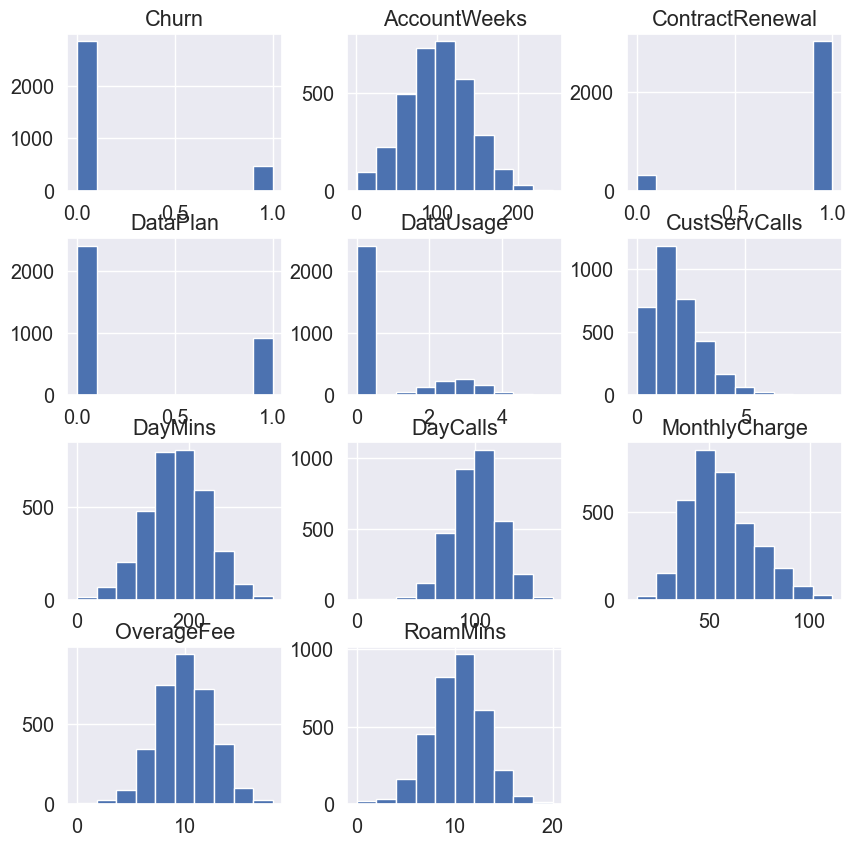

In [3]:
print('visualization of Churn dataset- histogram by variable:')
histogram1 = df.hist(figsize=(10,10))

**Initial observations:**
- Most of the Churns are 0 (makes sense, since most people don't leave their contract in a given month)
- Most of the variables are numerical, some are binary
- Most of the variables resemble a normal distribution
- CustServCalls, MonthlyCharge are skewed to the right
- DataUsage is a bit confusing, it seems like there is a group of users who don't use any data, and then a normal distribution of people who do? I guess that means DataUsage only applies to users where DataPlan == 1

In [4]:
#histogram by color by Churn
for col in df.columns:
    fig1 = px.histogram(df, x=col, color='Churn')
    fig1.show()

**Initial Observations**
- Most users who churn don't have a data plan (400 vs 80)
- The majority of users to who chrun don't have a data plan.
- It looks like most users who Churn have a higher than average MonthlyCharge

### Feature creation
Here we will generate polynomials, and add the ones considered most important by a random forest model in predicting churn. We output the AUC score for each set of features.

In [5]:

import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectFromModel

#define X and y
X = df.iloc[:,1:]
y = df.iloc[:,0] 


for d in [1,2,3]:
    #generate a dataset of polynomials
    poly = PolynomialFeatures(interaction_only=True, include_bias=False, degree=d)
    X_poly = poly.fit_transform(X)
    X_poly = pd.DataFrame(X_poly, columns=poly.get_feature_names_out())

    if d != 1:
        sel = SelectFromModel(RandomForestClassifier())
        
        sel.fit(X_poly, y)

        #get the columns that were most useful in prediction
        selected_feat= X_poly.columns[(sel.get_support())]
        X_poly = X_poly[selected_feat]

    #Evaluate model performance based on selected_features:
    rf = RandomForestClassifier()
 
    scores = cross_val_score(rf, X_poly, y, cv=5, scoring="roc_auc")

    # Evaluate ROC_AUC
    print("From generating dataset of interaction terms with degree %d, ROC AUC = %0.2f with a standard deviation of %0.2f" % (d, scores.mean(), scores.std()))

From generating dataset of interaction terms with degree 1, ROC AUC = 0.89 with a standard deviation of 0.02
From generating dataset of interaction terms with degree 2, ROC AUC = 0.90 with a standard deviation of 0.02
From generating dataset of interaction terms with degree 3, ROC AUC = 0.89 with a standard deviation of 0.03


Our first thought was to generate a lot of polynomial features but as shown above, this doesn't help the AUC performance for the Random Forest model. then after reading [this post on stack exchange](https://stats.stackexchange.com/questions/300254/does-feature-engineering-matter-when-doing-random-forest-or-gradient-boosting), one of the main intutitions was that "additional features and/or poorly engineered features increase the likelihood that you're training your model on noise rather than signal. Hence using domain knowledge or inspection of the data to suggest alternative ways to engineer features will usually improve results." Based on this, we'll read a bit more about churn before generating more features.

Churn, as defined above, is whether or not a customer opts out of a phone plan. Another way to think about it is that churn is a result of customer satisfaction. If a customer is happy- the utility they gain from staying is greater than the cost of staying with a mobile provider, the customer will stay. If the customer is unhappy- their utility is less than the cost of staying, they'll leave.

Understanding what goes into customer satistfaction can help us to create features to predict churn.



What makes a happy customer:
- Uses phone plan.
- Phone plan perks meet the needs of the customer (customer doesn't pay for extra stuff, and doesn't need more than he/she has)
- Monetary cost is low relative to the benefit derived from phone plan

What makes an unhappy customer:
- Doesn't use it
- Pays for extra stuff or feels like the plan doesn't meet his/her needs
- Monetary cost is expensive relative to benefit derived from plan

### Prepare df for models

In [6]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

## Random Forest

In [7]:
# Import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Instantiate rf
rf = RandomForestClassifier(max_depth=9, random_state=0)
 
scores = cross_val_score(rf, X_train, y_train, cv=5, scoring="roc_auc")

# Evaluate ROC_AUC
print("ROC AUC: %0.2f with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

ROC AUC: 0.89 with a standard deviation of 0.03


## XGBoost

In [8]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(max_depth=9, objective="reg:squarederror", random_state=1)

scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring="roc_auc")

# Evaluate ROC_AUC
print("ROC AUC: %0.2f with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

#I thought XGBoost was supposed to be really good, surprised it performed worse than random forest. Maybe changing the parameters (hyperparameter optimization) would lead to better AUC score

ROC AUC: 0.86 with a standard deviation of 0.02


### Feature Importance

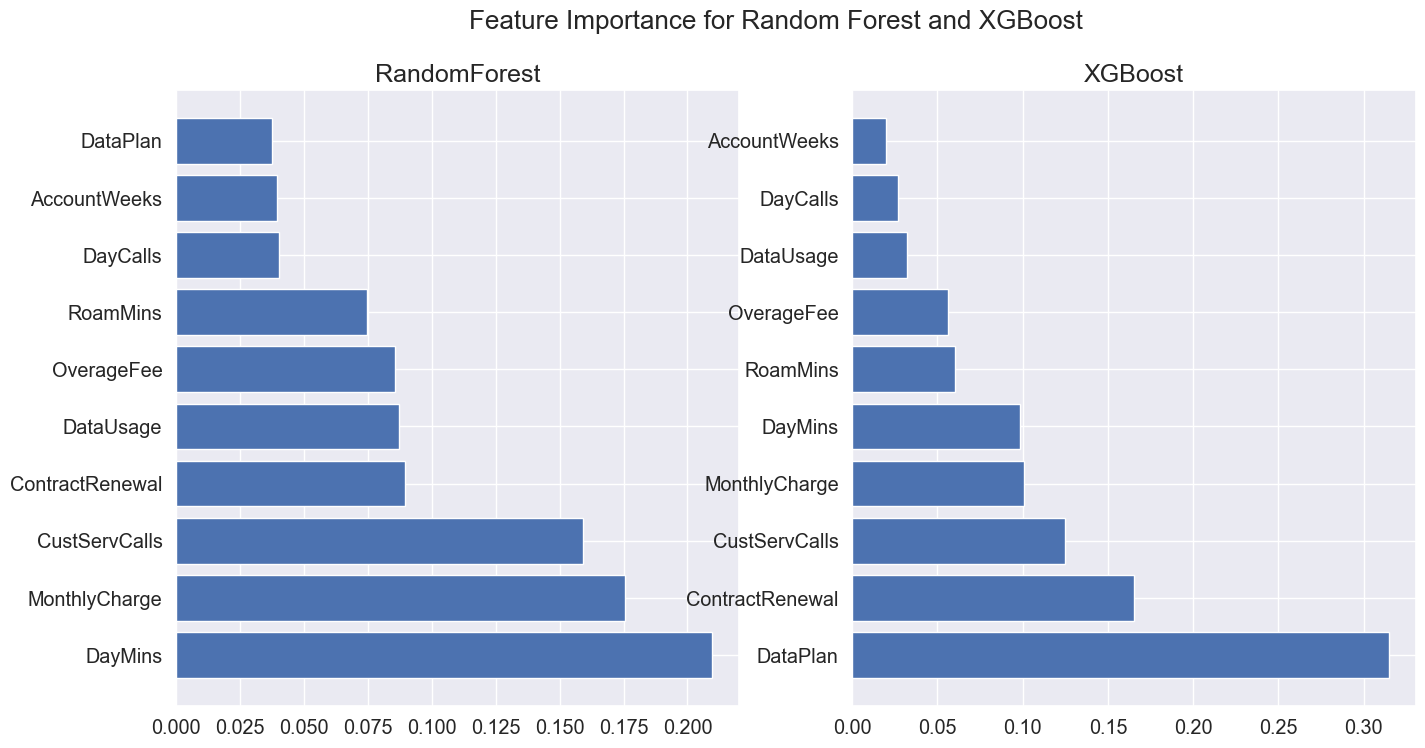

In [9]:
#Not sure how to get feature importance from cross_val_score above, so i am fitting the rf model to the X and y data to generate feature importances.


#DF of Feature importance for random forest
rf_feature_importance = pd.DataFrame(rf.fit(X, y).feature_importances_, index=X.columns, columns=['Importance']).sort_values(by='Importance', ascending=False)

#DF of Feature importance for random forest
xgb_feature_importance = pd.DataFrame(xgb_model.fit(X, y).feature_importances_, index=X.columns, columns=['Importance']).sort_values(by='Importance', ascending=False)

#plot results of feature importance
fig, axes = plt.subplots(1, 2, figsize=(16,8))
axes[0].barh(rf_feature_importance.index, rf_feature_importance.Importance)
axes[1].barh(xgb_feature_importance.index, xgb_feature_importance.Importance)
axes[0].set_title('RandomForest', fontsize=18)
axes[1].set_title('XGBoost', fontsize=18)
fig.suptitle('Feature Importance for Random Forest and XGBoost')
plt.show()

#I find it interesting that the two models have different variables they consider important. Especially DataPlan! Did I do this wrong or something lol

Some things we can explore:
- hyperparemeter optimization
- confusion matrices (maybe)
- feature importance- maybe create additional variables based on initial assessment of feature importance
- understand who are the customers most likely to churn
- what actions can be taken to stop them from leaving?


In [10]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)
{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

rf_random.best_params_

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy
base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)


from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, scoring='roc_auc',
                          cv = 3, n_jobs = -1, verbose = 2)


# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_
{'bootstrap': True,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 5,
 'min_samples_split': 12,
 'n_estimators': 100}
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)




{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   1.1s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   1.2s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   1.2s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=   3.8s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; tota